In [1]:
import sys
from typing import Callable, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

DATA_ROOT = '/mnt/ssd/data'

In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean: float = 0., std: float = 1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        return tensor + torch.randn(tensor.size()).to(tensor.device) * self.std + self.mean
    
    def __repr__(self) -> str:
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),
                                #AddGaussianNoise(0., 0.6)
                               ])

train_set = datasets.MNIST(DATA_ROOT, 
                           download=True, 
                           train=True,
                           transform=transform)

test_set = datasets.MNIST(DATA_ROOT, 
                          download=True, 
                          train=False,
                          transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


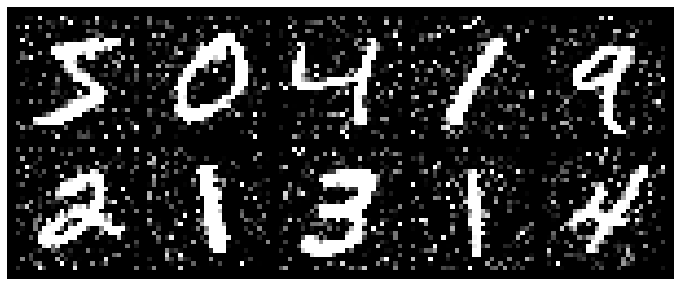

In [4]:
images = [AddGaussianNoise(0, 0.6)(train_set[i][0]) for i in range(10)]
grid = make_grid(images, nrow=5)
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.grid(False)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, n_channels: int = 1):
        super(Autoencoder, self).__init__()
        self.c1 = nn.Conv2d(n_channels, 8, kernel_size=3, padding=1, stride=2)
        self.c2 = nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2)
        self.c3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.c4 = nn.Conv2d(8, n_channels, kernel_size=3, padding=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.interpolate(x, scale_factor=2)
        x = F.relu(self.c3(x))
        x = F.interpolate(x, scale_factor=2)
        return self.c4(x)

In [6]:
LR = 1e-3
WEIGHT_DECAY = 1e-4
N_CHANNELS = 1
N_EPOCHS = 3
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

add_gaussian_noise = AddGaussianNoise(0, 0.6)

In [7]:
def train_epoch(train_loader: DataLoader, model: nn.Module, criterion: Union[Callable, nn.Module], 
                optimizer: torch.optim.Optimizer, device: str = 'cpu') -> float:
    
    model.train()
    losses = []
    
    pbar = tqdm(enumerate(train_loader), file=sys.stdout)
    for batch_idx, (X, _) in pbar:
        optimizer.zero_grad()
        
        X = X.to(device)
        X_noisy = add_gaussian_noise(X)
    
        out = model(X_noisy)
        loss = criterion(out, X)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        pbar.set_description(f'Loss: {loss.item()}')
    
    return np.mean(losses)

In [8]:
def validate(valid_loader: DataLoader, model: nn.Module, device: str = 'cpu') -> float:

    model.eval()
    losses = []
    
    pbar = tqdm(valid_loader, file=sys.stdout)
    for X, y in pbar:
    
        X = X.to(device)
        X_noisy = add_gaussian_noise(X)
    
        out = model(X_noisy)
        loss = criterion(out, X)
        
        losses.append(loss.item())

        pbar.set_description(f'Loss: {loss.item()}')
        
    return np.mean(losses)

In [9]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

model = Autoencoder(n_channels=N_CHANNELS).to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

Loss: 0.07295961678028107: : 1875it [00:09, 192.51it/s] 
Loss: 0.07254855334758759: 100%|██████████| 313/313 [00:01<00:00, 248.05it/s] 
Train Loss: 0.10844821775952974 | Test Loss: 0.06989768176033093


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


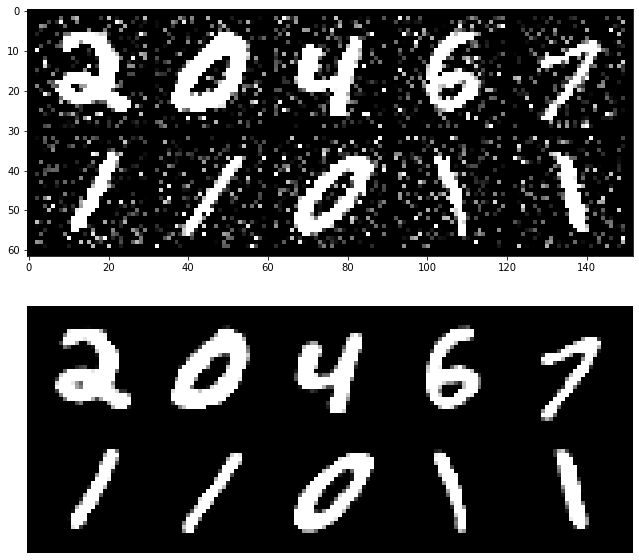

Loss: 0.062425777316093445: : 1875it [00:09, 194.74it/s]
Loss: 0.06354045122861862: 100%|██████████| 313/313 [00:01<00:00, 237.14it/s] 
Train Loss: 0.06608779059847196 | Test Loss: 0.06241848509008892


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


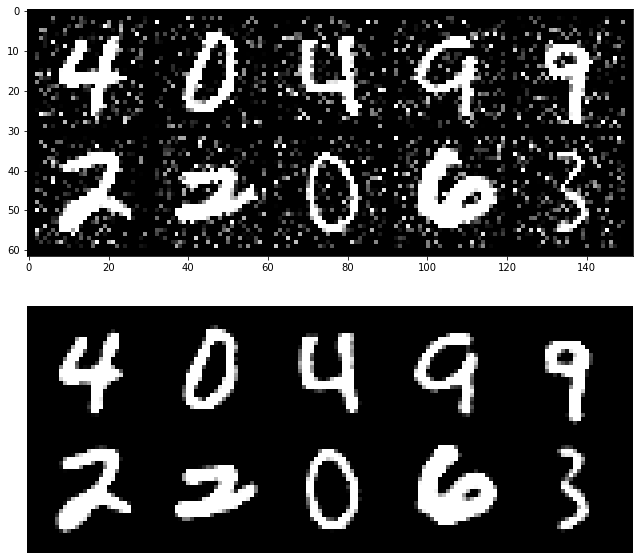

Loss: 0.06764320284128189: : 1875it [00:09, 194.12it/s] 
Loss: 0.06344780325889587: 100%|██████████| 313/313 [00:01<00:00, 255.60it/s] 
Train Loss: 0.061833300691843035 | Test Loss: 0.05954586069423932


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


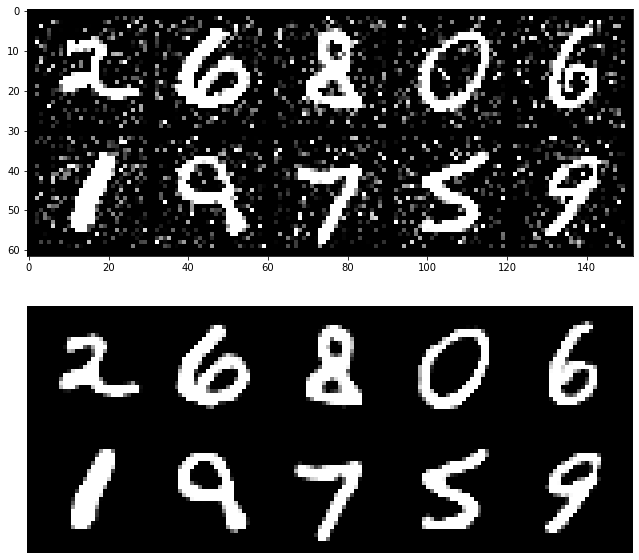

In [10]:
train_losses, test_losses = [], []

for e in range(N_EPOCHS):
    train_loss = train_epoch(train_loader, model, criterion, optimizer, DEVICE)
    test_loss = validate(test_loader, model, DEVICE)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Train Loss: {train_loss} | Test Loss: {test_loss}')
    
    with torch.no_grad():
        idx = torch.randint(len(test_set), (10,))
        imgs = torch.cat([test_set[i][0].unsqueeze(0) for i in idx], dim=0)
        imgs = add_gaussian_noise(imgs).to(DEVICE)
        grid_input = make_grid(imgs, nrow=5).cpu()
        out = model(imgs).detach().cpu()
        grid_out = make_grid(out, nrow=5)
        fig, axs = plt.subplots(2, 1, figsize=(20,10))
        axs[0].imshow(grid_input.permute(1, 2, 0))
        axs[1].imshow(grid_out.permute(1, 2, 0))
        plt.axis('off')
        plt.grid(False)
        plt.show()